# Description

Runs gaussian mixture model on the pca version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
INITIAL_RANDOM_STATE = 70000

## Input data

In [7]:
INPUT_SUBSET = "pca"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["CLUSTERING_NULL_DIR"],
    "data_transformations",
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/opt/data/results/clustering/null_sims/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

## Clustering

In [11]:
from sklearn.mixture import GaussianMixture

In [12]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [13]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["N_INIT"] = 10
CLUSTERING_OPTIONS["COVARIANCE_TYPE"] = "full"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 60,
 'N_REPS_PER_K': 5,
 'N_INIT': 10,
 'COVARIANCE_TYPE': 'full'}

In [14]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = GaussianMixture(
            n_components=k,
            n_init=CLUSTERING_OPTIONS["N_INIT"],
            covariance_type=CLUSTERING_OPTIONS["COVARIANCE_TYPE"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [15]:
display(len(CLUSTERERS))

295

In [16]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('GaussianMixture #0',
 GaussianMixture(n_components=2, n_init=10, random_state=70000))

('GaussianMixture #1',
 GaussianMixture(n_components=2, n_init=10, random_state=70001))

In [17]:
clustering_method_name = method_name
display(clustering_method_name)

'GaussianMixture'

## Output directory

In [18]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_NULL_DIR"],
    "runs",
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/opt/data/results/clustering/null_sims/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [19]:
data = pd.read_pickle(input_filepath)

In [20]:
data.shape

(3752, 50)

In [21]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,0.373237,-0.155188,-1.554390,-0.103733,-1.807074,-0.957108,0.330335,0.638391,0.905023,-0.704551,...,0.161732,0.488682,0.761158,0.667089,-0.078934,0.840971,-0.622958,1.075964,3.244039,-0.933407
100002_raw-Energy,1.384398,0.511267,-0.273603,-0.074591,-1.151167,-0.069438,1.242634,-0.439543,0.650348,2.456117,...,0.051967,0.993820,-0.166350,1.497041,-0.875754,2.632726,0.613299,0.041232,4.032974,-0.230092
100003_raw-Protein,-1.247583,2.905641,-1.524196,0.683773,0.766860,-2.478057,-0.201110,1.045590,-0.844712,2.426349,...,0.027646,-1.903636,-0.819195,0.616887,-0.647462,0.170956,2.106036,-2.186258,0.485333,-1.136366
100004_raw-Fat,-0.695167,0.046286,0.730428,0.240547,1.621534,-1.335187,-1.510894,1.790966,-0.682884,-1.572835,...,-2.997557,-0.489466,0.442809,1.217098,-1.604667,-0.776865,-0.983076,0.080423,2.476131,0.431179
100005_raw-Carbohydrate,0.770055,-0.499034,0.053157,0.479019,2.048336,0.984552,-0.090767,0.053451,-0.614035,1.304292,...,-0.280231,-0.892308,-0.522105,-0.358232,1.690968,0.049799,-0.633466,-0.812035,0.901284,2.461845


In [22]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [23]:
from clustering.ensembles.utils import generate_ensemble

In [24]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 295/295 [1:51:12<00:00, 22.62s/it]


In [25]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [26]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
GaussianMixture #0,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #1,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
GaussianMixture #2,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
GaussianMixture #3,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
GaussianMixture #4,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [27]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [28]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [29]:
assert ensemble_stats["min"] > 1

In [30]:
assert not ensemble["n_clusters"].isna().any()

In [31]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [32]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [33]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [34]:
from sklearn.metrics import calinski_harabasz_score

In [35]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [36]:
ensemble.shape

(295, 4)

In [37]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
GaussianMixture #0,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,6.206695
GaussianMixture #1,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,6.395688
GaussianMixture #2,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,6.395688
GaussianMixture #3,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,6.351231
GaussianMixture #4,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,6.478781


## Save

In [38]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [39]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,6.365617
3,8.196385
4,6.559148
5,6.765293
6,9.357208
7,9.319371
8,8.424254
9,9.309323
10,10.688764


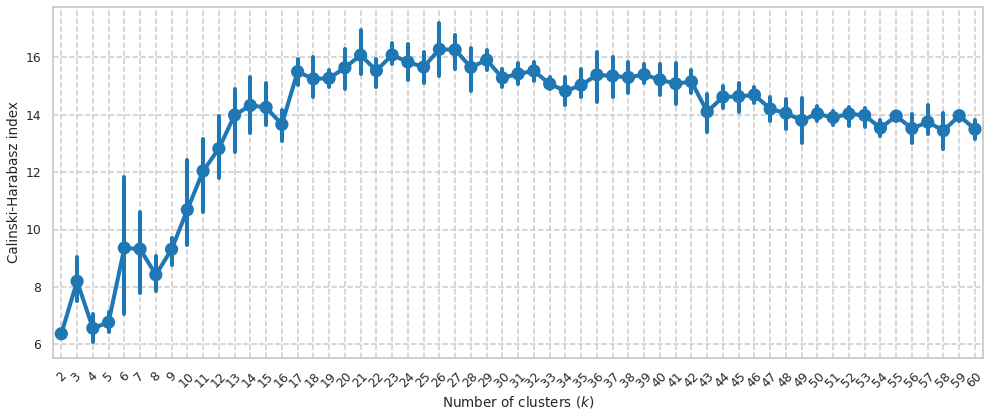

In [41]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [42]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [43]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
4    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
5    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
6    [[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,...
dtype: object

In [44]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [45]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [46]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [47]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

2     0.983580
3     0.739058
4     0.603691
5     0.402932
6     0.394077
7     0.251560
8     0.218804
10    0.129351
9     0.100517
11    0.065200
45    0.034858
56    0.033457
50    0.033330
59    0.032703
58    0.032632
Name: k, dtype: float64

In [48]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [49]:
parts_ari_df.shape

(59, 10)

In [50]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [51]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,0.983684,0.983684,0.972821,0.972821,1.000000,0.977944,0.988966,0.977944,0.988966,0.988966
3,0.792142,0.717186,0.817745,0.780548,0.647118,0.766189,0.732444,0.672758,0.690567,0.773881
4,0.588878,0.588712,0.571236,0.580601,0.661443,0.648473,0.617256,0.591357,0.584442,0.604511
5,0.382932,0.394194,0.315747,0.399407,0.453427,0.356894,0.399063,0.463097,0.470489,0.394072
6,0.167815,0.267730,0.339272,0.217400,0.575757,0.258681,0.682879,0.432304,0.653059,0.345871


## Save

In [52]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-stability-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [53]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [54]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [55]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [56]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,0.983684
1,2,1,0.983684
2,2,2,0.972821
3,2,3,0.972821
4,2,4,1.000000


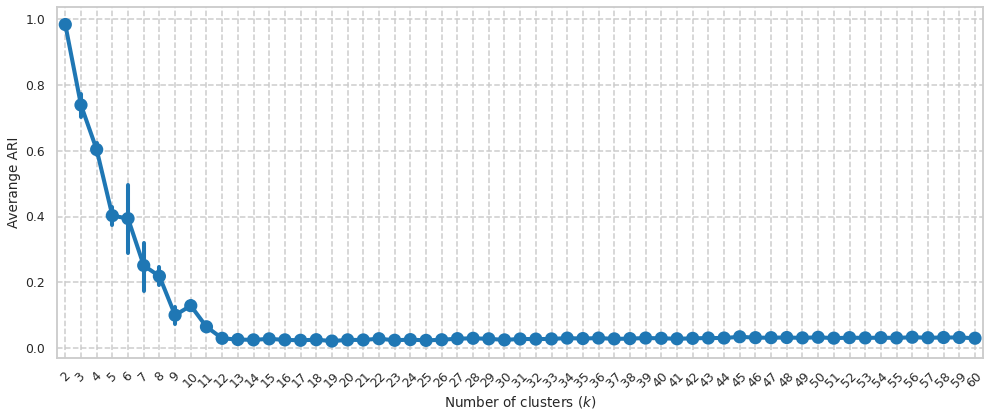

In [57]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()